<a href="https://colab.research.google.com/github/KajetanFrackowiak/tensorflow_fundamentals/blob/main/10_Milestone_Project_3_Time_series_forecasting_in_TensorFlow_(BitPredict).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1650 (UUID: GPU-f010ab2c-9f8a-dfc2-d888-045d09377d67)


In [8]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
import requests
url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"
response = requests.get(url)
if response.status_code == 200:
    print("Download successful!")
else:
    print(f"Error downloading the file. Status code: {response.status_code}")
    exit()

with open("BTC_USD.csv", "wb") as f:
    f.write(response.content)
    print("File saves as BTC_USD.csv")

Download successful!
File saves as BTC_USD.csv


In [11]:
import pandas as pd

# Parse dates and set date column to index
df = pd.read_csv("BTC_USD.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [13]:
len(df)

2787

In [104]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


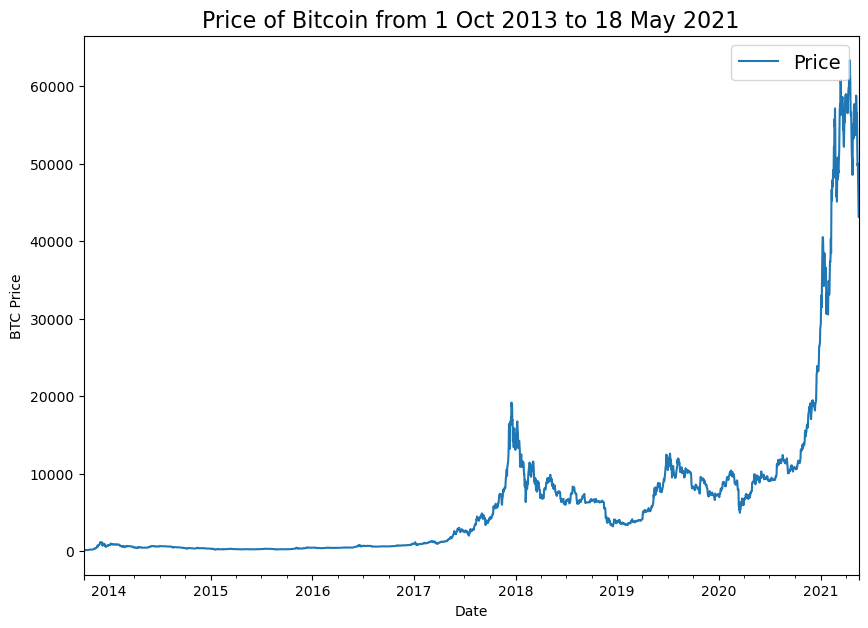

In [105]:
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

In [106]:
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("BTC_USD.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader)  # skip the first line
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

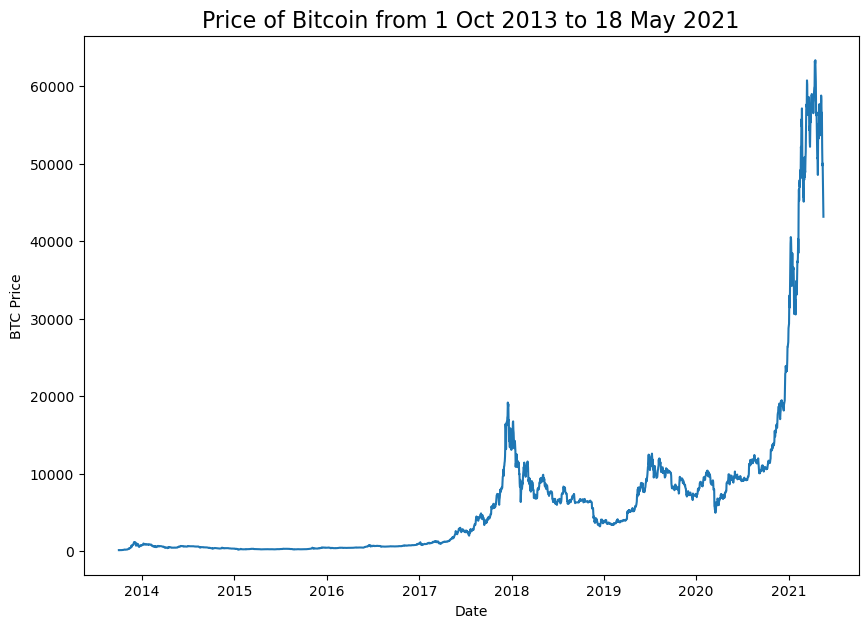

In [107]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

In [20]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

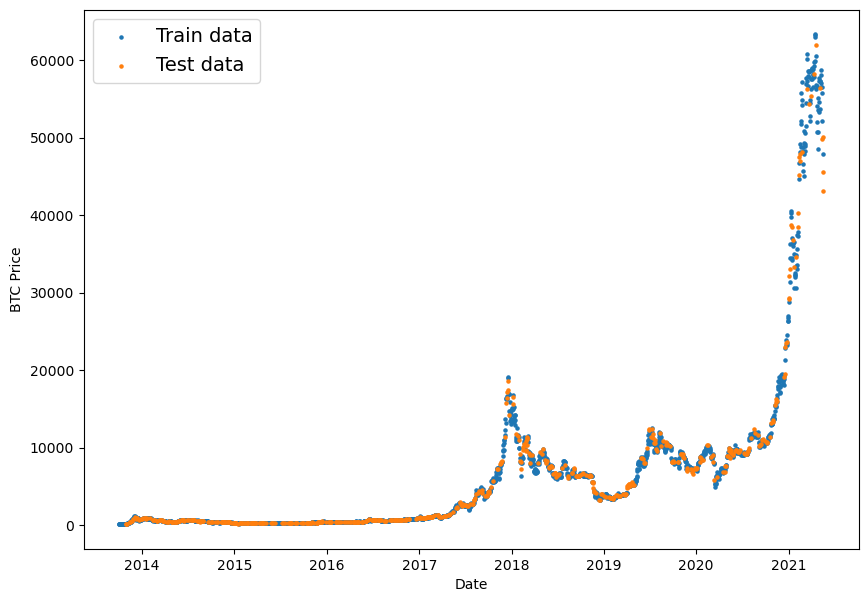

In [22]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

In [23]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices))

# Create train data splits (everything before split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2229, 2229, 558, 558)

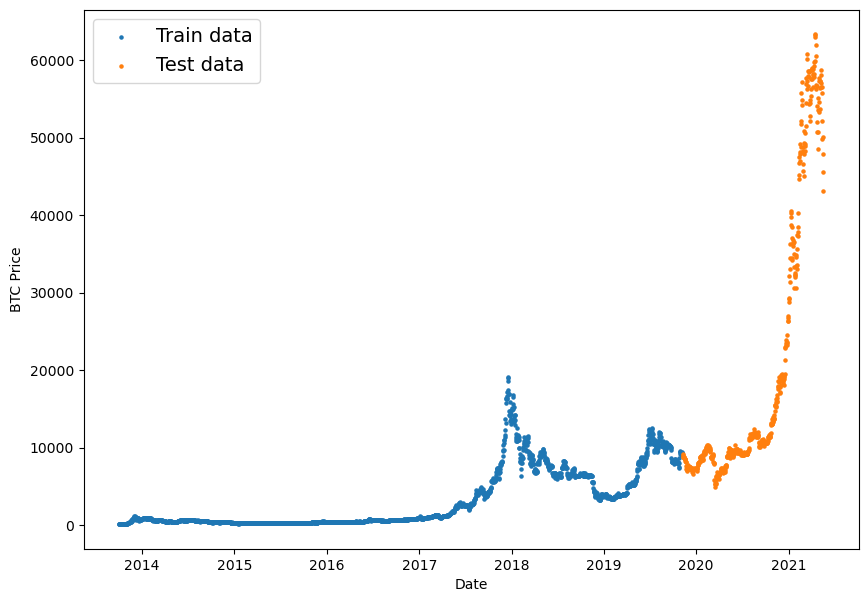

In [24]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

In [25]:
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots a timesteps against values.

  Parameters
  ----------
  timesteps: timesteps: array of timesteps
  values: array of valyes accros time
  format: style of plot, default "."
  start: where to start the plot
  end: where to end the plot
  label: label to show on plot of values
  """
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

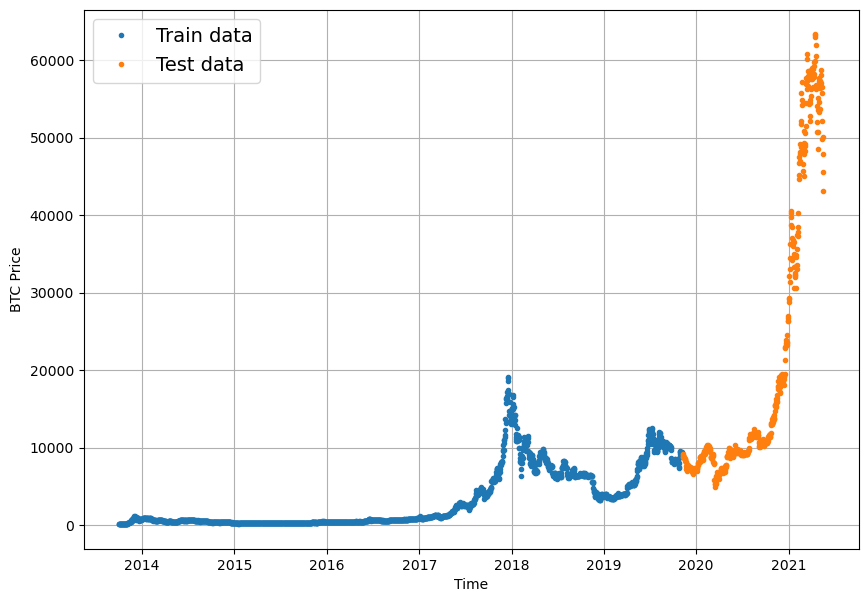

In [26]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")


In [27]:
# Create a naive forecast
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

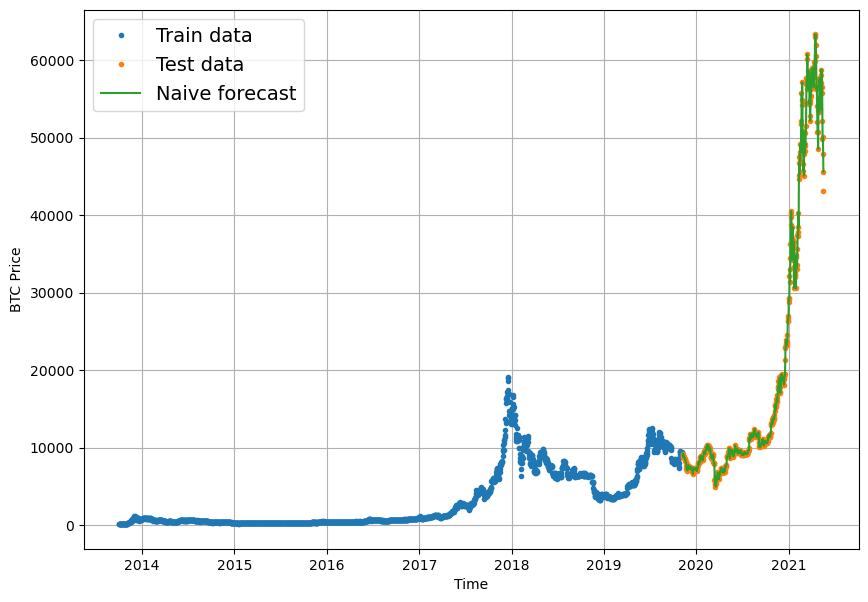

In [28]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

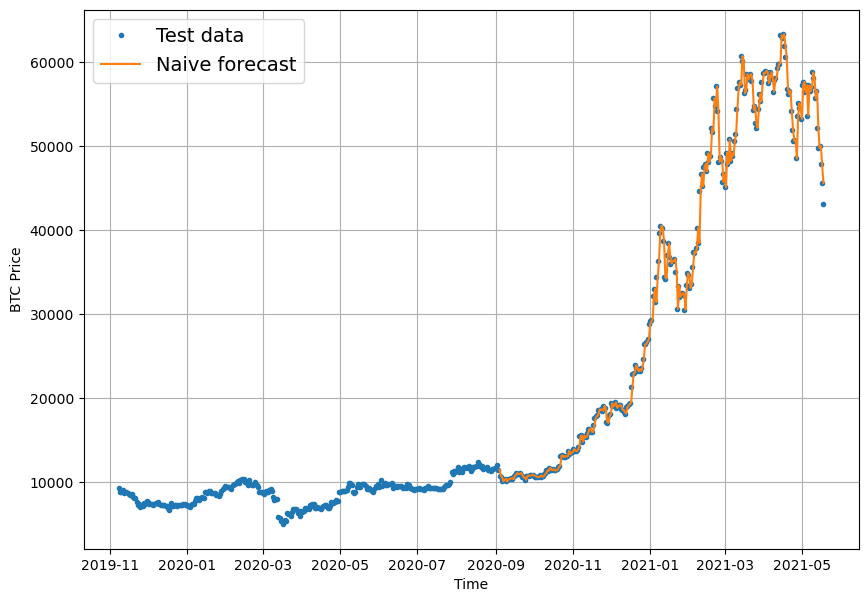

In [29]:
# Zoom in to take a better look
plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

In [30]:
import tensorflow as tf

tf.__version__

'2.16.1'

In [31]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implemen MASE(assuming no seasonality of data)
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))  # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [32]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [33]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)

naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [34]:
# Find the average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737226

In [35]:
HORIZON = 1  # predict 1 step at a time
WINDOW_SIZE = 7  # use a week worth of timesteps to predict horizon

In [36]:
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [1,2,3,4,5,6] -> Output: ([1,2,3,4,5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [37]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [231]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window size.
  """
  # 1. Create a window of specific window_size
  window_step = tf.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T  # create 2D array of windows of size window_size

  # 3. Index on the target array (time series) with 2D array of multiple window size
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [39]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [40]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [41]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label [43144.47129086]


In [42]:
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windwos and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [43]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [44]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [175]:
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name + ".keras"),
                                            verbose=0,
                                            save_best_only=True)

In [51]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

In [52]:
model_1.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 286.6385 - mae: 286.6385 


[571.5105590820312, 571.5105590820312]

In [53]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained_model
  input_data: windowed input data

  Returns model predictions on input data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [54]:
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8882.809, 8798.079, 9057.6  , 8846.208, 8749.883, 8727.74 ,
       8726.208, 8560.528, 8458.203, 8557.588], dtype=float32)>

In [55]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 571.51056,
 'mse': 1174989.0,
 'rmse': 1083.9691,
 'mape': 2.560467,
 'mase': 1.0039858}

In [56]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

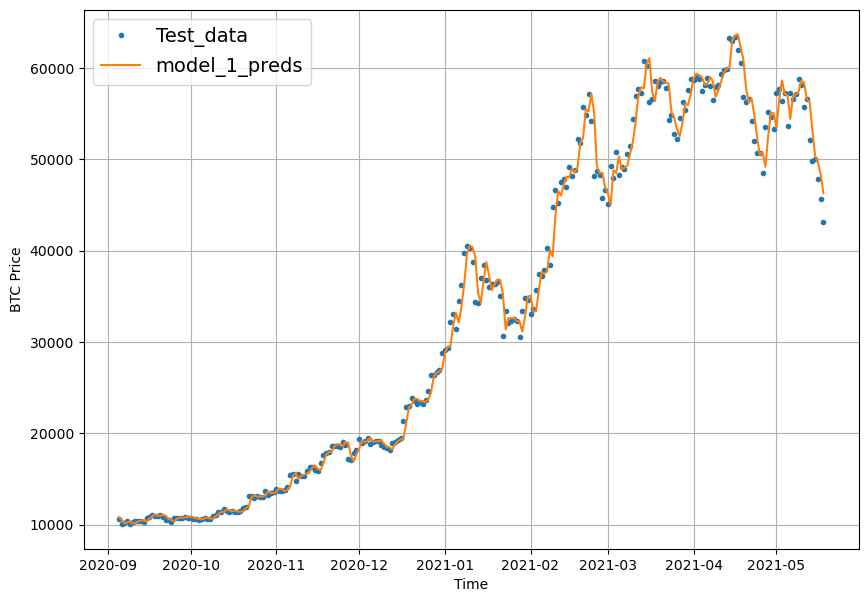

In [57]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

In [232]:
HORIZON = 1
WINDOW_SIZE = 30

In [59]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [60]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [61]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [62]:
model_2.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 392.4025 


736.4754028320312

In [65]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense.keras")
model_2.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 312.9158


608.7136840820312

In [66]:
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [67]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                    y_pred=model_2_preds)
model_2_results

{'mae': 608.71375,
 'mse': 1293423.2,
 'rmse': 1137.2877,
 'mape': 2.8050184,
 'mase': 1.0640374}

In [68]:
HORIZON = 1
WINDOW_SIZE = 90
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)

tf.random.set_seed(42)

model_2_V2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_V2_dense")

model_2_V2.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

model_2_V2.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2_V2.name)])

In [69]:
model_2_V2.evaluate(test_windows, test_labels)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 416.7081 


725.5057983398438

In [70]:
model_2_V2_preds = make_preds(model_2_V2,
                           input_data=test_windows)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [71]:
model_2_V2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_V2_preds)
model_2_V2_results

{'mae': 725.5058,
 'mse': 1474309.6,
 'rmse': 1214.2115,
 'mape': 3.5971463,
 'mase': 1.2488787}

In [72]:
model_2_results

{'mae': 608.71375,
 'mse': 1293423.2,
 'rmse': 1137.2877,
 'mape': 2.8050184,
 'mase': 1.0640374}

In [203]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)

In [204]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [205]:
model_3.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 639.7311


1272.5845947265625

In [207]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense.keras")
model_3.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 632.1884


1254.806640625

In [208]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:2]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


<tf.Tensor: shape=(2, 7), dtype=float32, numpy=
array([[9160.79 , 9222.615, 9006.009, 9296.82 , 9342.619, 9344.353,
        9353.924],
       [8659.792, 8765.38 , 8620.778, 8944.494, 8840.163, 8872.268,
        8974.227]], dtype=float32)>

In [209]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [210]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1254.8066,
 'mse': 5213148.0,
 'rmse': 1429.1466,
 'mape': 5.6724916,
 'mase': 2.232858}

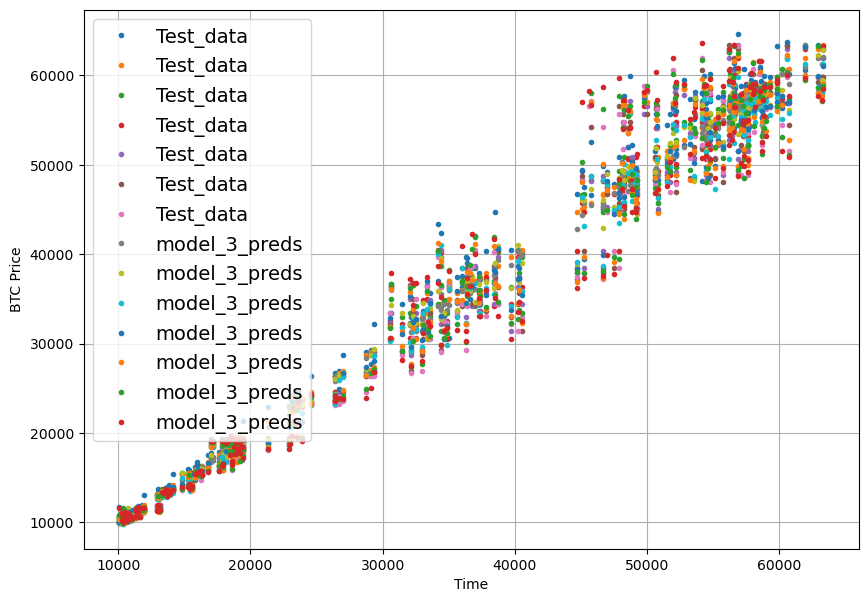

In [211]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

ValueError: x and y must have same first dimension, but have shapes (256, 7) and (251,)

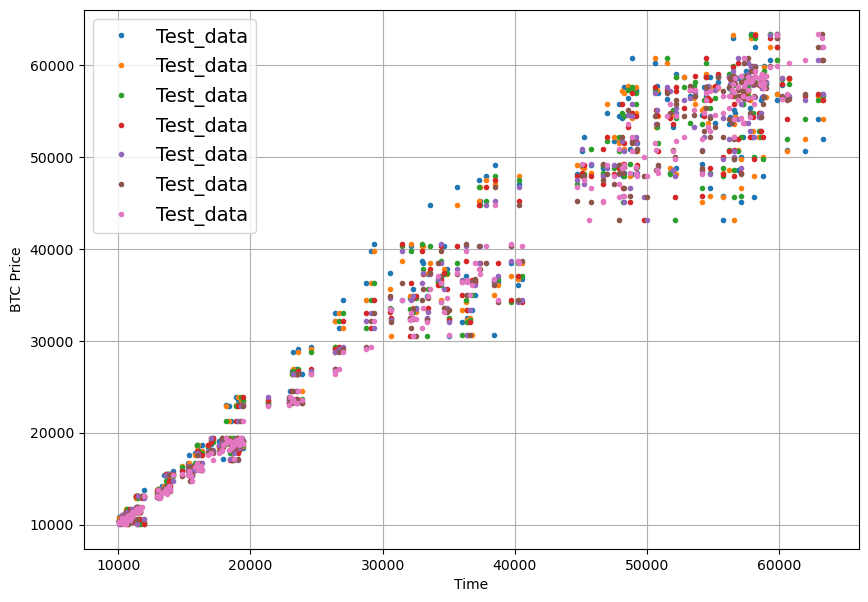

In [233]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format="-",
                 start=offset,
                 label="model_3_preds")

<Axes: >

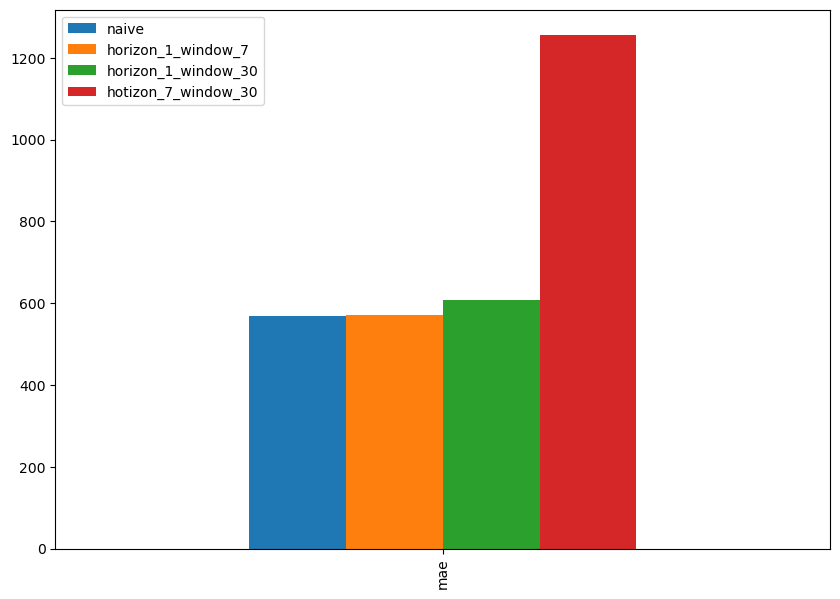

In [214]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "hotizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar")

## Model 4: Conv1D

In [243]:
HORIZON = 1
WINDOW_SIZE = 7
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [216]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [217]:
train_windows[0].shape

(7,)

In [218]:
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(expand_dims_layer(x))

Original shape: (7,)
Expanded shape: (7, 1)
tf.Tensor(
[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]], shape=(7, 1), dtype=float32)


In [234]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_conv1D")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [235]:
model_4.summary()

Model: "model_4_conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)               │ (None, 1, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 128)         │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 1, 1)           │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,213 (55.52 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,476 (37.02 KB)

In [237]:
# model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D.keras")
# model_4.evaluate(test_windows, test_labels)

In [238]:
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8897.429 , 8821.133 , 9043.348 , 8805.287 , 8781.8125, 8763.75  ,
       8696.597 , 8566.28  , 8486.752 , 8548.147 ], dtype=float32)>

In [239]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 566.4425,
 'mse': 1170083.4,
 'rmse': 1081.704,
 'mape': 2.534506,
 'mase': 0.9950826}

In [248]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(WINDOW_SIZE,))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [253]:
# tf.keras.config.enable_unsafe_deserialization()
# model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm.keras")
# model_5.evaluate(test_windows, test_labels)

In [254]:
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8883.108, 8768.544, 8956.575, 8761.591, 8709.528, 8702.709,
       8662.375, 8514.093, 8432.136, 8488.905], dtype=float32)>

In [255]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 580.40314,
 'mse': 1206016.8,
 'rmse': 1098.188,
 'mape': 2.603103,
 'mase': 1.0196075}

In [256]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [257]:
block_reward_1 = 50  # 2009-01-03
block_reward_2 = 25  # 2012-11-28
block_reward_3 = 12.5  # 2016-07-09
block_reward_4 = 6.25

block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [258]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [259]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing in iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


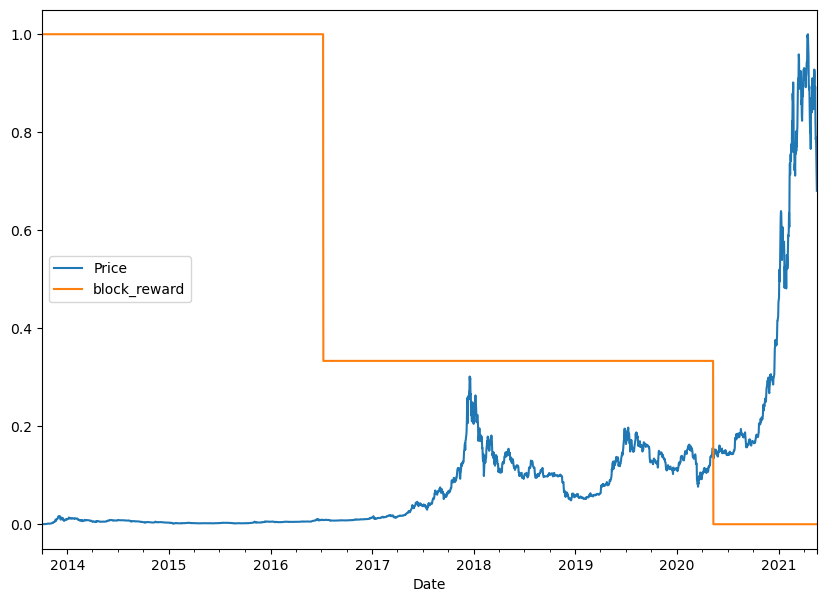

In [260]:
from sklearn.preprocessing import minmax_scale

scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

In [261]:
HORIZON = 1
WINDOW_SIZE = 7

In [262]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [263]:
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [264]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [265]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [267]:
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate.keras")
model_6.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 282.4200 


566.0464477539062

In [268]:
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8848.282, 8793.727, 9050.874, 8779.104, 8739.973, 8739.489,
       8676.862, 8533.233, 8458.015, 8535.71 ], dtype=float32)>

In [269]:
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 566.04645,
 'mse': 1161588.2,
 'rmse': 1077.77,
 'mape': 2.5300288,
 'mase': 0.99438685}

In [270]:
model_1_results

{'mae': 571.51056,
 'mse': 1174989.0,
 'rmse': 1083.9691,
 'mape': 2.560467,
 'mase': 1.0039858}

In [271]:
tf.random.set_seed(42)

model_6_V2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_V2_dense_multivariate")

model_6_V2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_6_V2.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6_V2.name)])

In [272]:
model_6_V2 = tf.keras.models.load_model("model_experiments/model_6_V2_dense_multivariate.keras")
model_6_V2

<Sequential name=model_6_V2_dense_multivariate, built=True>

In [273]:
model_6_V2_preds = tf.squeeze(model_6_V2.predict(X_test))
model_6_V2_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8837.872, 8764.722, 9060.996, 8754.101, 8723.14 , 8759.538,
       8666.298, 8492.041, 8454.44 , 8529.403], dtype=float32)>

In [274]:
model_6_V2_results = evaluate_preds(y_true=y_test,
                                    y_pred=model_6_V2_preds)
model_6_V2_results

{'mae': 568.78345,
 'mse': 1156687.2,
 'rmse': 1075.4939,
 'mape': 2.5593936,
 'mase': 0.999195}

In [275]:
# Create NBeatsBlock custom Layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):  # the **kwargs atgument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta Layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):  # the call methos is what runs when the layer is called
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [276]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,  # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [277]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)  # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>

In [278]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.47611687  0.10651746  0.12173551 -0.45829263  0.2972337  -0.11761669
  0.12219406]
Forecast: -0.18054257333278656


In [279]:
HORIZON = 1
WINDOW_SIZE = 7

In [280]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [281]:
bitcoin_prices_nbeats =  bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [282]:
# Make featues and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [283]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appedix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [284]:
# Values from N_BEATS paper Figure 1 and Table 18/Appedix D
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON  # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [285]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Substract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [287]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")
# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in substraction residual link
residuals = layers.subtract([stack_input, backcast], name=f"substract_00")

# 4. Create stack of blocks
for i, _ in enumerate(range(N_STACKS-1)):  # first stack is already created in (3)
  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"substract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=200, verbose=1)])


Epoch 345: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
CPU times: total: 6min 31s
Wall time: 8min 17s


In [288]:
model_7.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 567.2117 - mae: 567.2117 - mse: 1145183.3750


[567.211669921875, 567.211669921875, 1145183.375]

In [289]:
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8780.092, 8755.175, 9020.581, 8747.4  , 8796.387, 8705.584,
       8635.906, 8524.637, 8439.   , 8513.907], dtype=float32)>

In [290]:
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 567.2116,
 'mse': 1145183.1,
 'rmse': 1070.1323,
 'mape': 2.5411482,
 'mase': 0.9964337}

In [303]:
model_7.name

'model_7_N-BEATS'

In [318]:
from tensorflow.keras.models import save_model
from tensorflow.keras.utils import custom_object_scope

with custom_object_scope({'NBeatsBlock': NBeatsBlock}):
    save_model(model_7, "model_experiments/model_7_N-BEATS.h5")

ValueError: Unable to synchronously create dataset (name already exists)

In [319]:
from tensorflow.keras.models import load_model

# Assuming your model is saved as 'model_experiments/model_7_N-BEATS.h5'
loaded_model = load_model('model_experiments/model_7_N-BEATS.h5',
                          custom_objects={'NBeatsBlock': NBeatsBlock})


ValueError: Unknown layer: 'NBeatsBlock'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [320]:
model_7.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 567.2117 - mae: 567.2117 - mse: 1145183.3750


[567.211669921875, 567.211669921875, 1145183.375]

## Model 8: Creating an ensemble

In [321]:
def get_ensemble_models(horizon=HORIZON,
                       train_data=train_dataset,
                       test_data=test_dataset,
                       num_iter=10,
                       num_epochs=100,
                       loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE, and MAPE loss.

  For example, if num_iter=10, a lsit of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"])
  """
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      model = tf.keras.Sequential([
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(HORIZON)
      ])

      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                 patience=100,
                                                                 verbose=1)])
      # Append fittend model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [322]:
%%time
# Get lis of trained ensembel models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 733: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 833: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 192: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 707: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 807: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 578: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 691: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 791: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by redu

In [323]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [324]:
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8821.727,  8799.543,  9098.993, ..., 50701.17 , 49200.76 ,
        46232.188],
       [ 8804.907,  8811.112,  8991.963, ..., 49644.152, 47960.31 ,
        46013.227],
       [ 8773.263,  8809.396,  9060.058, ..., 50256.32 , 48040.914,
        46039.656],
       ...,
       [ 8753.521,  8755.48 ,  9017.248, ..., 49761.27 , 49123.38 ,
        47374.3  ],
       [ 8739.984,  8664.264,  9080.663, ..., 49528.33 , 48406.34 ,
        46188.03 ],
       [ 8738.947,  8787.116,  9032.073, ..., 50383.945, 48122.496,
        46334.53 ]], dtype=float32)>

In [325]:
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0))
ensemble_results

{'mae': 571.14624,
 'mse': 1149282.8,
 'rmse': 1072.046,
 'mape': 2.577455,
 'mase': 1.0033457}

In [326]:
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks
  # 2. Measure the standard deviaition of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the prediction inverval upper na lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bound of the 95 %
lower, upper = get_upper_lower(preds=ensemble_preds)

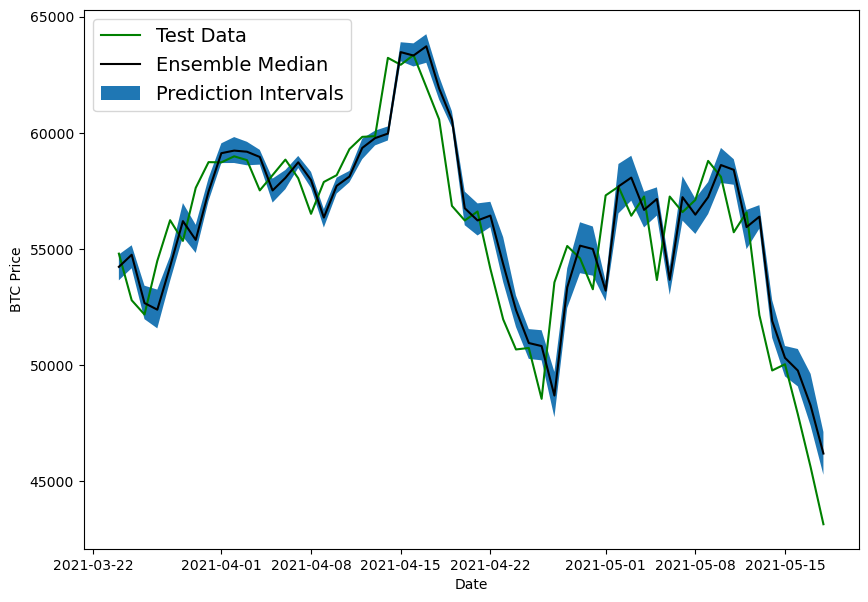

In [327]:
ensemble_median = np.median(ensemble_preds, axis=0)

offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

### Model 9: Train a model on the full historical data to make predictions into future

In [328]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [329]:
# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [330]:
# 1. Turn X and y tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [331]:
tf.random.set_seed(42)

model_9 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
])

model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

model_9.fit(dataset_all,
            epochs=100,
            verbose=0)

In [332]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14

In [333]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [334]:
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 54957.484375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 54957.484375  ] -> Prediction: 51778.5625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 54957.484375   51778.5625    ] -> Prediction: 48922.25

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 54957.484375   51778.5625     48922.25      ] -> Prediction: 47600.8515625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 54957.484375
 51778.5625     48922.25       47600.8515625 ] -> Prediction: 46668.01953125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predict

In [335]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [336]:
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [337]:
next_time_steps = get_future_dates(start_date=last_timestep,
                                  into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [338]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 54957.484, 51778.562, 48922.25 , 47600.85 , 46668.02 ,
        46379.336, 48207.285, 53624.45 , 50295.477, 47411.92 , 46547.53 ,
        47105.1  , 48216.168, 50399.402], dtype=float32))

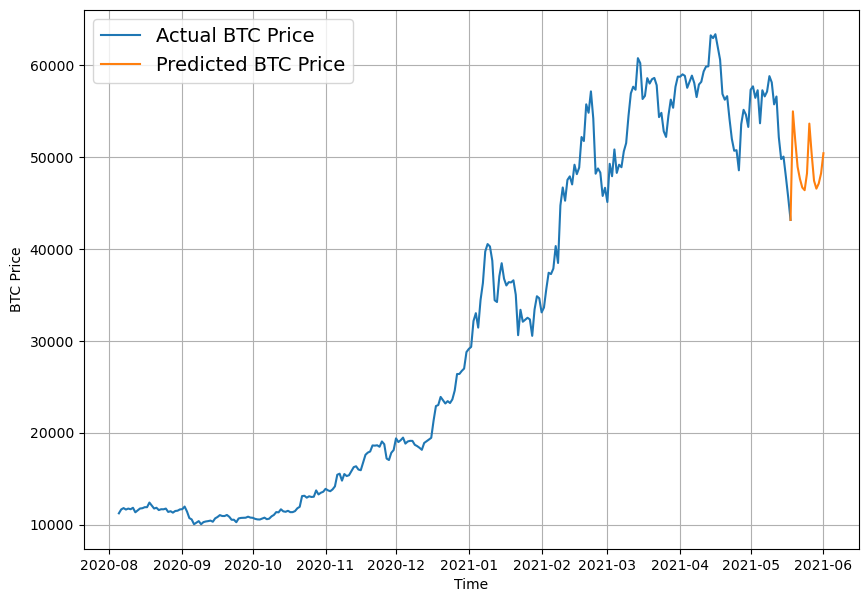

In [339]:
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

### Model 10: Why forecasting is BS (the turkey problem)

In [340]:
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [341]:
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

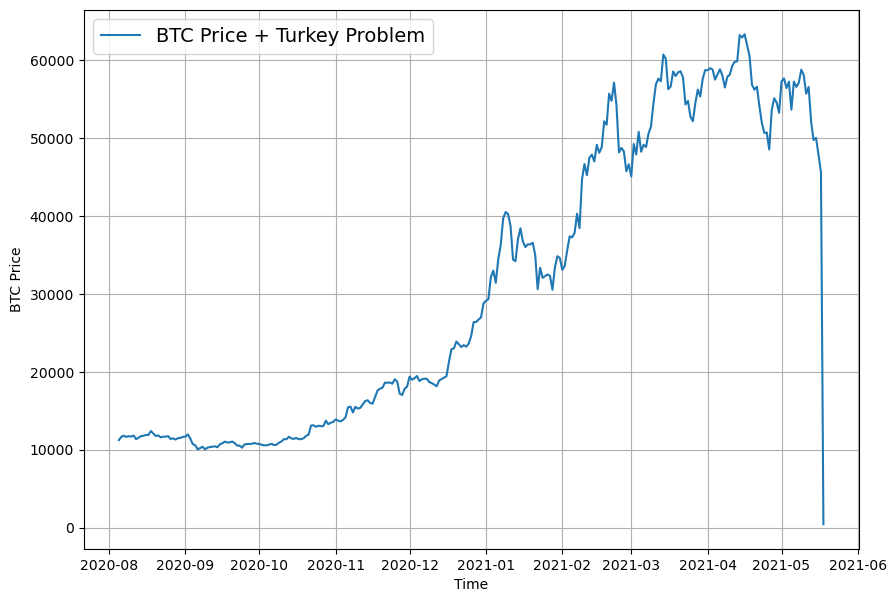

In [342]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                format="-",
                label="BTC Price + Turkey Problem",
                start=2500)

In [343]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(y_train)

(2224, 2224)

In [344]:
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model.name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

In [345]:
turkey_model.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 297.1871


655.8763427734375

In [192]:
turkey_model = tf.keras.models.load_model("model_experiments/Turkey_Model.keras")
turkey_model.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 288.2125  


640.4305419921875

In [193]:
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8829.252, 8770.623, 9057.548, 8772.176, 8729.374, 8742.674,
       8680.025, 8508.182, 8459.011, 8533.693], dtype=float32)>

In [197]:
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 640.4306,
 'mse': 4822735.5,
 'rmse': 640.4306,
 'mape': 21.3688,
 'mase': 26.498707}

In [198]:
model_1_results

{'mae': 571.51056,
 'mse': 1174989.0,
 'rmse': 1083.9691,
 'mape': 2.560467,
 'mase': 1.0039858}

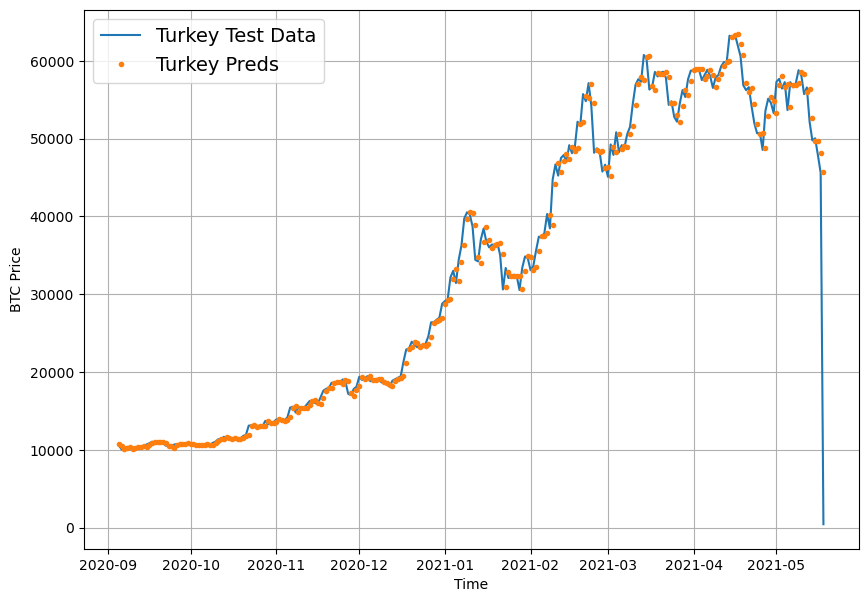

In [199]:
plt.figure(figsize=(10, 7))
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset);

In [347]:
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_NBEATs": model_7_results,
                              "model_8_ensemble": ensemble_results,
                              "model_9_turkey": turkey_results}).T
model_results

,mae,mse,rmse,mape,mase
naive_model,567.980225,1147547.000,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,571.510559,1174989.000,1083.969116,2.560467,1.003986
model_2_dense_w30_h1,608.713745,1293423.250,1137.287720,2.805018,1.064037
model_3_dense_w30_h7,1254.806641,5213148.000,1429.146606,5.672492,2.232858
model_4_CONV1D,566.442505,1170083.375,1081.703979,2.534506,0.995083
model_5_LSTM,580.403137,1206016.750,1098.187988,2.603103,1.019608
model_6_multivariate,566.046448,1161588.250,1077.770020,2.530029,0.994387
model_7_NBEATs,567.211609,1145183.125,1070.132324,2.541148,0.996434
model_8_ensemble,571.146240,1149282.750,1072.046021,2.577455,1.003346
model_9_turkey,640.430603,4822735.500,640.430603,21.368799,26.498707


<Axes: >

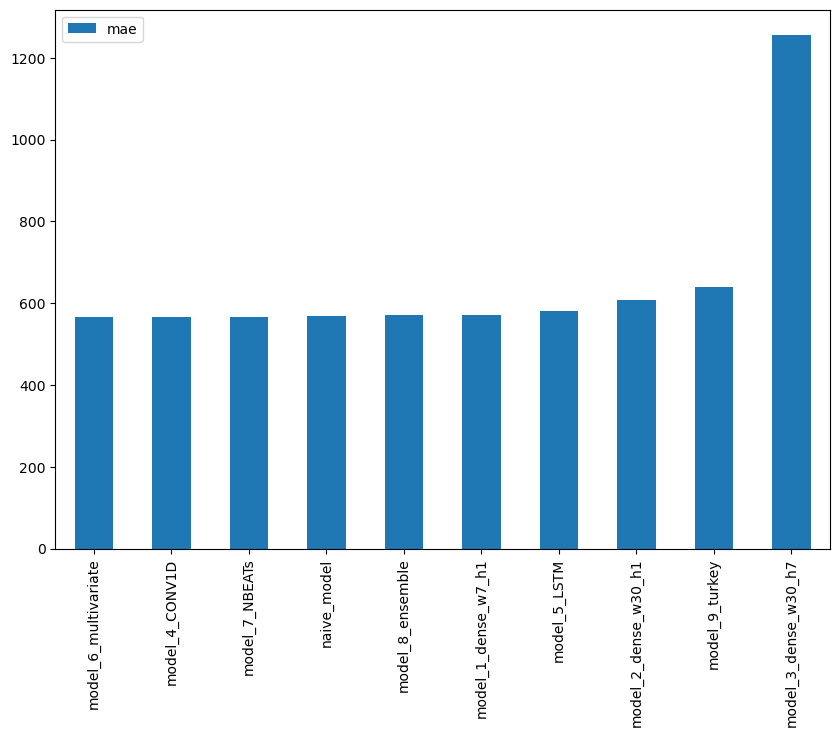

In [349]:
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar")